In [1]:
# ----- LIBS

# geoprocessamento
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely.geometry import box
from shapely.geometry import mapping

# normalizar
import numpy as np
from shapely.geometry import mapping
from sklearn.preprocessing import MinMaxScaler

# plots
import matplotlib.pyplot as plt

# gerar e visualizar csv
import csv
import pandas as pd

# Extração de shapes e Plots da Unicamp

- Extração de região geográfica de interesse (bbbike) no formato .shp
- Plot de shapes

In [2]:
# Apontando para o path do dataset do Mapa de Edificações 
# - https://unicamp-arcgis.maps.arcgis.com/apps/View/index.html?appid=1d96ada62af4451bb4972b9779d09e66

import os

current_path = os.getcwd()
# print(current_path)
# print(current_path.find('obstacle_exp'))
# print(current_path[0:current_path.find('obstacle_exp')])

map_dataset_path = current_path[0:current_path.find('obstacle_exp')]
building_shp_path = "datasets/unicamp-arcgis-dataset/edificacoes.shp"

unicamp_building_dataset_path = map_dataset_path + building_shp_path

In [3]:
# ----- READ BUILDING SHAPES DATASET

unicamp_df = gpd.read_file(unicamp_building_dataset_path)
# unicamp_roads_df = gpd.read_file(unicamp_roads_dataset_path)

print('SHAPE:', unicamp_df.shape)
unicamp_df.head(2)

SHAPE: (1170, 8)


,Id,PREDIO,NOME_DO_PR,UNIDADE,GlobalID,Shape_Leng,Shape_Area,geometry
0,444.0,8.0,CASA NO BREAK,"INSTITUTO DE FÍSICA""GLEB WATAGHIN"" (IFGW)",{A3AA0550-2317-433F-888F-BBA6148200AF},49.024480,135.943591,"POLYGON Z ((287762.773 7475309.137 0.000, 2877..."
1,65.0,11.0,DEPÓSITO DE MATERIAIS - DEM,HOSPITAL DE CLÍNICAS (HC),{418DC5B5-3050-40D4-BC58-E4BDFA11D4F3},56.199993,190.900186,"POLYGON Z ((288123.323 7474311.958 0.000, 2881..."


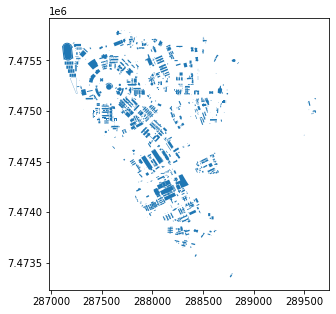

In [4]:
# ----- Plot UNICAMP MAPA Edificações
ax = unicamp_df.plot(figsize=(12, 5))

In [5]:
# Add coluna com centroids

unicamp_df['centroids'] = unicamp_df.centroid
# unicamp_df['centroids']
unicamp_df.head(2)

,Id,PREDIO,NOME_DO_PR,UNIDADE,GlobalID,Shape_Leng,Shape_Area,geometry,centroids
0,444.0,8.0,CASA NO BREAK,"INSTITUTO DE FÍSICA""GLEB WATAGHIN"" (IFGW)",{A3AA0550-2317-433F-888F-BBA6148200AF},49.024480,135.943591,"POLYGON Z ((287762.773 7475309.137 0.000, 2877...",POINT (287754.847 7475304.757)
1,65.0,11.0,DEPÓSITO DE MATERIAIS - DEM,HOSPITAL DE CLÍNICAS (HC),{418DC5B5-3050-40D4-BC58-E4BDFA11D4F3},56.199993,190.900186,"POLYGON Z ((288123.323 7474311.958 0.000, 2881...",POINT (288127.015 7474321.129)


In [6]:
# predio = unicamp_df[unicamp_df['UNIDADE'].str.contains("INOVA",  na=False)]
# print("SHAPE:", predio.shape)
# predio.head()

# Normalização de Mapa da Unicamp

In [7]:
# Bounds of Unicamp Map
unicamp_minx, unicamp_miny, unicamp_maxx, unicamp_maxy = unicamp_df.geometry.total_bounds

print('bounds:', unicamp_minx, unicamp_miny, unicamp_maxx, unicamp_maxy)
print('x:', unicamp_maxx-unicamp_minx)
print('y:', unicamp_maxy- unicamp_miny)

bounds: 287109.0126 7473356.5109 289617.4537000004 7475795.9585
x: 2508.441100000404
y: 2439.4475999996066


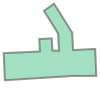

In [8]:
# get all geometries of unicamp_utm_df
unicamp_geometries = [i for i in unicamp_df.geometry]

# geometry example
unicamp_geometries[2]

In [9]:
map_minx = 1e+10
map_maxx = -1
map_miny = 1e+10
map_maxy = -1

for geometry in range(len(unicamp_geometries)):
    
    # get all coordinates (x,y) of polygons in unicamp_utm_df
    all_coords_per_geometry = mapping(unicamp_geometries[geometry])["coordinates"] 

    # split all coordinates per geometry and get x coords and y coords
    x_coords = [all_coords_per_geometry[0][i][0] for i in range(len(all_coords_per_geometry[0]))]
    y_coords = [all_coords_per_geometry[0][i][1] for i in range(len(all_coords_per_geometry[0]))]
    
    # convert to 2D array
    x_coords = np.array(x_coords)
    y_coords = np.array(y_coords)
    
    # get all geometry coords in x and y
    if geometry == 0:
        all_coords_x = x_coords.copy()
        all_coords_y = y_coords.copy()
    else:
        all_coords_x = np.append (all_coords_x, x_coords.copy(), axis=0)
        all_coords_y = np.append (all_coords_y, y_coords.copy(), axis=0)
        
    # get bounds limits of map and compare with unicamp_utm_df.geometry.total_bounds
    # after for loop, limits must be equal
    if np.min(x_coords) < map_minx:
        map_minx = np.min(x_coords)
    if np.max(x_coords) > map_maxx:
        map_maxx = np.max(x_coords)
    
    if np.min(y_coords) < map_miny:
        map_miny = np.min(y_coords)
    if np.max(y_coords) > map_maxy:
        map_maxy = np.max(y_coords)
    

# after for loop, limits must be equal
print(map_minx, map_miny,map_maxx, map_maxy)
print(unicamp_minx, unicamp_miny, unicamp_maxx, unicamp_maxy)
# yey

# convert to 2D array 
x = np.array(all_coords_x).reshape(-1, 1) # reshape -> 2D array
y = np.array(all_coords_y).reshape(-1, 1)

287109.0126 7473356.5109 289617.4537000004 7475795.9585
287109.0126 7473356.5109 289617.4537000004 7475795.9585


In [10]:
# create a normalized map with unicamp bounds

# criando novo mapa, que conterá geometrias normalizadas
mapa_normalizado = gpd.GeoDataFrame(columns=["id","building_number","building_name","unit", "geometry"])
mapa_normalizado['id'] = unicamp_df['Id']
mapa_normalizado['building_number'] = unicamp_df['PREDIO']
mapa_normalizado['building_name'] = unicamp_df['NOME_DO_PR']
mapa_normalizado['unit'] = unicamp_df['UNIDADE']

# processo de normalização
for geometry in range(len(unicamp_geometries)):

    # get all coordinates (x,y) of polygons in unicamp_utm_df
    all_coords_per_geometry = mapping(unicamp_geometries[geometry])["coordinates"] 
    
    # split all coordinates per geometry and get x coords and y coords
    x_coords = [all_coords_per_geometry[0][i][0] for i in range(len(all_coords_per_geometry[0]))]
    y_coords = [all_coords_per_geometry[0][i][1] for i in range(len(all_coords_per_geometry[0]))]
    
    # convert to 2D array
    x_coords = np.array(x_coords).reshape(-1, 1) 
    y_coords = np.array(y_coords).reshape(-1, 1)
    
    # define limits of normalization
    scaler_x = MinMaxScaler(feature_range = (0, unicamp_maxx - unicamp_minx))
    scaler_y = MinMaxScaler(feature_range = (0, unicamp_maxy - unicamp_miny))
    
    # normalize with all all geometry coords x 
    scaler_x.fit(x)
    transform_x = scaler_x.transform(x_coords)
    
    # normalize with all all geometry coords y
    scaler_y.fit(y)
    transform_y = scaler_y.transform(y_coords)
    
    # convert np array x and y normalized back to polygon
    building_geometry = np.append (transform_x, transform_y, axis=1)
    new_polygon = Polygon(building_geometry)
    
    mapa_normalizado.loc[geometry, 'geometry'] = new_polygon
    

print('Shape do Mapa normalizado:', mapa_normalizado.shape)
mapa_normalizado.head(3)

Shape do Mapa normalizado: (1170, 5)


,id,building_number,building_name,unit,geometry
0,444.0,8.0,CASA NO BREAK,"INSTITUTO DE FÍSICA""GLEB WATAGHIN"" (IFGW)","POLYGON ((653.760 1952.626, 653.921 1944.120, ..."
1,65.0,11.0,DEPÓSITO DE MATERIAIS - DEM,HOSPITAL DE CLÍNICAS (HC),"POLYGON ((1014.311 955.448, 1010.857 962.105, ..."
2,1282.0,4.0,SALAS DE AULA,"FAC.ENGa.CIVIL,ARQ. E URBANISMO","POLYGON ((1278.073 1971.314, 1278.638 1957.955..."


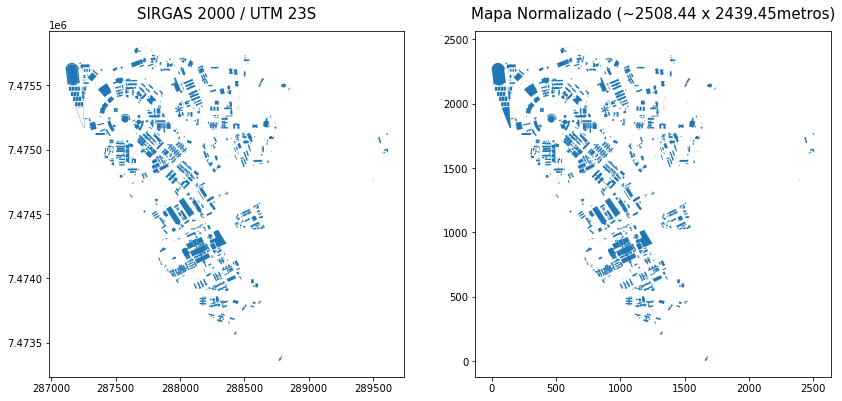

In [11]:
# ANTES E DEPOIS DA NORMALIZAÇÃO

fig, axes = plt.subplots(1,2, figsize = (14, 7)) # 1 linha, 2 colunas

# Mapa da unicamp no crs SIRGAS 2000/ UTM 23S
axes[0].set_title('SIRGAS 2000 / UTM 23S', fontsize=15, y=1.02)
unicamp_df.plot(ax=axes[0])

# Mapa da Unicamp
# onde:
# - unicamp bounds = 285960.71918678837 7473387.272237044 290348.567447891 7476048.738107968
# - maxx - minx    = 4387.848261102627
# - maxy - miny    = 2661.465870924294
title = 'Mapa Normalizado (~' + str(round(unicamp_maxx-unicamp_minx,2)) + ' x ' + str(round(unicamp_maxy-unicamp_miny,2)) + "metros)" 
axes[1].set_title(title,fontsize=15, y=1.02)
mapa_normalizado.plot(ax=axes[1])

plt.show()

In [12]:
mapa_normalizado.head(3)

,id,building_number,building_name,unit,geometry
0,444.0,8.0,CASA NO BREAK,"INSTITUTO DE FÍSICA""GLEB WATAGHIN"" (IFGW)","POLYGON ((653.760 1952.626, 653.921 1944.120, ..."
1,65.0,11.0,DEPÓSITO DE MATERIAIS - DEM,HOSPITAL DE CLÍNICAS (HC),"POLYGON ((1014.311 955.448, 1010.857 962.105, ..."
2,1282.0,4.0,SALAS DE AULA,"FAC.ENGa.CIVIL,ARQ. E URBANISMO","POLYGON ((1278.073 1971.314, 1278.638 1957.955..."


In [13]:
# ----- FUNÇÕES ÚTEIS P/ MANIPULAÇÃO DE SHAPES

def get_polygon_coords (polygon):
    g = [i for i in polygon.geometry]
    x,y = g[0].exterior.coords.xy
    coords = np.dstack((x,y)).tolist()
    
    return coords

def create_box_building(building_name, bounds, offset_xmin, offset_ymin, offset_xmax, offset_ymax):
    new_building = box(
        bounds[0] - offset_xmin,
        bounds[1] - offset_ymin,
        bounds[2] -offset_xmax,
        bounds[3] -offset_ymax
    )

    print("Bounds do prédio " + str(building_name) + ":", bounds)
    print("\nÁrea:", new_building.area)
    print("Length:", new_building.length)
    
    return new_building


def compare_buildings(ref_building, new_building):
    geodataset_ref = gpd.GeoSeries(ref_building)
    ax = geodataset_ref.plot(color='Gray')

    geodataset_new = gpd.GeoSeries(new_building)
    geodataset_new.plot(ax=ax) 

    
def calculate_distance(ref_polygon, new_polygon):
    points_df = gpd.GeoDataFrame(columns=["geometry"])
    points_df.loc[:, 'geometry'] = ref_polygon
    points_df.loc[0, 'geometry'] = new_polygon

    points_df['centroid'] = points_df["geometry"].centroid

    # Cálculo de Distância entre Circle centroids e cada linha do dataset
    print("Distancia entre centroids:\n", points_df.distance(new_polygon.centroid))

    return points_df


def add_dataset_rows(geodataset, ref_id, name, geometry):
    last_index = geodataset.shape[0]
    geodataset.loc[last_index, 'id'] = ref_id
    geodataset.loc[last_index, 'building_number'] = ref_id
    geodataset.loc[last_index, 'building_name'] = name
    geodataset.loc[last_index, 'unit'] = '{aaa}'
    geodataset.loc[last_index, 'geometry'] = geometry
    
    print("Novo Shape:", geodataset.shape)
    
    return geodataset.iloc[geodataset.shape[0]-1:geodataset.shape[0]]


def add_node_dataset_rows(geodataset, ref_osm_id, name, point):
    last_index = geodataset.shape[0]
    print(last_index)
    geodataset.loc[last_index, 'id'] = ref_osm_id
    geodataset.loc[last_index, 'number'] = ref_osm_id
    geodataset.loc[last_index, 'name'] = name
    geodataset.loc[last_index, 'x'] = point.x
    geodataset.loc[last_index, 'y'] = point.y
    geodataset.loc[last_index, 'z'] = 1.5
    
    print("Novo Shape:", geodataset.shape)
    
    return geodataset.iloc[geodataset.shape[0]-1:geodataset.shape[0]]

## Buscar e Mapear predios

In [14]:
# ----- RESULTADOS DO MAPEAMENTO (prédios com coletores) # id da tabela, id do dataset, num_predio

# ENCONTRADOS POR CONSULTA DE NOME:
# 1. Agência de Inovação Inova Unicamp (INOVA)  # 701, 1321.0 , 1.0 
# 2. Biblioteca Central (BC)   # 765, 535.0, 5.0
# 3. Centro de Biologia Molecular e Engenharia Genética (CBMEG)   # 688, 802.0, 9.0
# 4. Centro de Componentes Semicondutores (CCS)   # 175.0, 1.0 ~
# 5. Centro de Computação (CCUEC)   # 600, 845.0, 8.0
# 6. Centro de Diagnóstico de Doenças do Aparelho Digestivo (GASTROCENTRO) # 315, 1037.0, 6.0
# 7. Centro de Estudos de Petróleo (CEPETRO) # 539, 1115.0, 6.0
# 8. Centro de Hematologia e Hemoterapia (HEMOCENTRO) # 852, 1038.0, 7.0
# 9. Centro para Manutenção de Equipamentos (CEMEQ) # 219, 960.0, 15.0 
# 10. Ciclo Básico I   #  760, 671.0, 11.0 
# 11. Ciclo Básico II  #  753, 663.0, 3.0
# 12. Coordenadoria de Desenvolvimento Cultural (CDC) # 787, 533.0, 3.0
# 13. Diretoria Geral da Administração (DGA) # 193, 29.0, 1.0
# 14. Diretoria Geral de Recursos Humanos (DGRH) # 209, 9.0, 5.0
# 15. Divisão de Educação Infantil e Complementar (DEdIC) # 863, 1211.0, 1.0
# 16. Engenharia Básica (EB)  # 175.0, 1.0 ~
# 17. Escola Estadual de Ensino Fundamental Físico Sérgio Pereira Porto (SERGIO PORTO) # 297, 1220.0, 10.0
# 18. Faculdade de Ciências Médicas (FCM) # 867, 1238.0, 1.0 
# 19. Faculdade de Educação Física (FEF)  # 790, 727.0, 30.0
# 20. Faculdade de Enfermagem (FEnf)      # 880, 1240.0, 3.0
# 21. Faculdade de Engenharia Agrícola (FEAGRI)   # 674, 881.0, 1.0
# 22. Faculdade de Engenharia Civil, Arquitetura e Urbanismo (FEC)  # 2, 1282.0, 4.0
# 23. Faculdade de Engenharia de Alimentos (FEA)   # 253, 300.0, 2.0
# 24. Faculdade de Engenharia Elétrica e de Computação (FEEC) # 234, 278.0, 2.0
# 25. Faculdade de Engenharia Mecânica (FEM)   # 286, 1151.0, 6.0
# 26. Faculdade de Engenharia Química (FEQ)    # 396, 971.0, 28.0
# 27. Fundação de Desenvolvimento da Unicamp (FUNCAMP) # --------
# 28. Gabinete do Reitor (GR)      # 39, 1.0, 1.0
# 29. Grupo Gestor de Obras (GGO)  # 212, 195.0, 8.0
# 30. Hospital de Clínicas (HC)    # 115, 59.0, 6.0
# 31. Instituto de Artes (IA)      # 24, 513.0, 2.0
# 32. Instituto de Biologia (IB)   # 441, 604.0, 5.0
# 33. Instituto de Computação (IC) # 571, 776.0, 2.0
# 34. Instituto de Estudos da Linguagem (IEL) # 525, 488.0, 5.0
# 35. Instituto de Filosofia e Ciências Humanas (IFCH) # 540, 1112.0, 3.0
# 36. Instituto de Física Gleb Wataghin (IFGW) # 399, 441.0, 5.0
# 37. Instituto de Geociências (IG) da Rua Oswaldo Cruz (inferior) 183, 182.0, 8
# 38. Instituto de Geociências (IG) da Avenida Érico Veríssimo (superior) 1066, 1134.0, 1.1
# 39. Instituto de Matemática, Estatística e Computação Científica (IMECC) # 513, 459.0, 1.0
# 40. Instituto de Química (IQ) # 341, 376.0, 16.0
# 41. Prefeitura Universitária # 203, 4.0, 2.0
# 45. Restaurante Administrativo (RA) # 37, 198.0, 10.0
# 46. Restaurante Saturnino (RS) # 636, 1309.0, 1.0
# 47. Restaurante Universitário (RU) # 775, 531.0, 1.0

# NÃO ESTÃO NO MAPA:
# 27. Fundação de Desenvolvimento da Unicamp (FUNCAMP) # --------

# Casos especiais:
# 42. Ponto de ônibus – Rua Roxo Moreira (PO-RM)
# 43. Ponto de ônibus – Avenida Adolpho Lutz (PO-AL)
# 44. Ponto de ônibus – Rua Vital Brasil (PO-VB)

In [15]:
# ----- MÉTODOS DE BUSCA PARA MAPEAMENTO

# Busca por linha em todo dataset
predio = mapa_normalizado.iloc[775:776] #ex Comvest 536-537
# print(mapa_normalizado.shape)
predio.head(predio.shape[0])

# Busca por Nome
# predio = mapa_normalizado[mapa_normalizado['building_name'].str.contains("PRÉDIO DO IG",  na=False)]
# # predio = mapa_normalizado[mapa_normalizado['unit'].str.contains("RU",  na=False)]
# print("SHAPE:", predio.shape)
# predio.head(22)

,id,building_number,building_name,unit,geometry
775,531.0,1.0,RESTAURANTE UNIVERSITÁRIO - RU,REITORIA-PREFEITURA,"POLYGON ((229.926 1860.477, 241.953 1803.958, ..."


In [16]:
# predio.plot(color="red")

<AxesSubplot:>

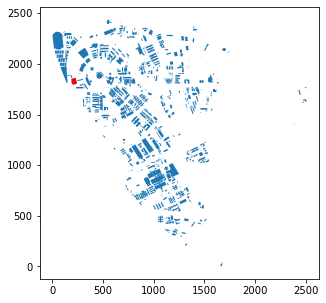

In [17]:
### ----- PLOT DE PREDIO DE ACORDO COM A BUSCA REALIZADA

ax = mapa_normalizado.plot(figsize=(12, 5))

# predios None
predio['geometry'].plot(ax=ax, color='Red')

# Para ampliar area mudar param. de set_xlim e set_ylim
# minx, miny, maxx, maxy = mapa_normalizado.total_bounds
# ax.set_xlim(minx -100, maxx)
# ax.set_ylim(miny -100, maxy)

In [18]:
mapa_normalizado[mapa_normalizado.shape[0]-5:mapa_normalizado.shape[0]]

,id,building_number,building_name,unit,geometry
1165,1445.0,4.0,Academia de Ginástica ao Ar Livre,None,"POLYGON ((701.642 1223.634, 714.261 1224.555, ..."
1166,0.0,0.0,None,None,"POLYGON ((536.049 1540.335, 536.049 1567.085, ..."
1167,0.0,0.0,None,None,"POLYGON ((570.032 1482.662, 564.833 1482.547, ..."
1168,0.0,4.0,Inova P&D,INOVA,"POLYGON ((1498.018 2134.044, 1498.209 2134.395..."
1169,0.0,0.0,Instituto de Otorrinolaringologia,None,"POLYGON ((1186.929 1019.863, 1202.243 992.924,..."


## Reposicionando posicionamento do CCS e EB 

In [19]:
# Tratamento para que prédio do CCS e EB não tenham o mesmo centroid 
# 175.0, 1.0 ~
point_IG = mapa_normalizado.query('id ==' + str(175.0))
# point_IG
print(point_IG['geometry'].centroid)

189    POINT (939.805 1193.583)
dtype: geometry


(1000.0, 1300.0)

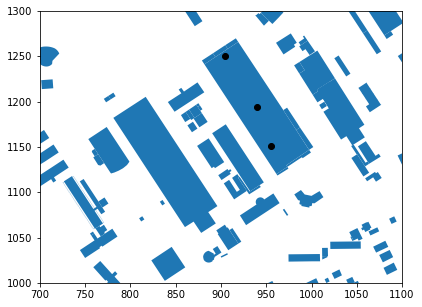

In [20]:
# Reposicionando posicionamento do CCS e EB (para que não tenham o mesmo centroid)
pt_CCS = Point (955.805, 1150.583)
pt_EB  = Point (905, 1250.583)

# Plot de paradas de ÔNIBUS
df = gpd.GeoDataFrame(columns=["geometry"],  crs='EPSG:31983')
df.loc[0, 'geometry'] = pt_CCS
df.loc[1, 'geometry'] = Point (939.805, 1193.583) # centroid do predio em comum
df.loc[2, 'geometry'] = pt_EB

ax = mapa_normalizado['geometry'].plot(figsize=(12, 5))
df.plot(ax=ax, color="black")

# para ampliar area mudar param. de set_xlim e set_ylim
minx, miny, maxx, maxy = mapa_normalizado.total_bounds
ax.set_xlim(700, 1100)
ax.set_ylim(1000, 1300)

# Cria e ADD Pontos não encontrados

### FUNCAMP

In [21]:
# Prédio de Referência: COMVEST
ref_id = 536 # index da linha do prédio COMVEST
ref_polygon = mapa_normalizado.iloc[ref_id:ref_id + 1] # ex Comvest 536-537
# get_polygon_coords(ref_polygon)

Bounds do prédio FUNCAMP: [671.4345000004396, 2364.147699999623, 694.7207000004128, 2379.911700000055]

Área: 260.70115679071546
Length: 67.89959999918938


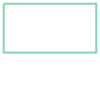

In [22]:
bounds_ref = list(ref_polygon.geometry.total_bounds)
building_funcamp = create_box_building("FUNCAMP", bounds_ref, -110, -107, -64.5, -79.5)
building_funcamp.boundary

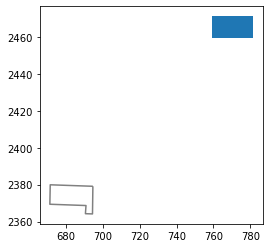

In [23]:
compare_buildings(ref_polygon['geometry'].boundary, building_funcamp )

In [24]:
# CALCULA DISTANCIA ENTRE CENTROIDS
calculate_distance(ref_polygon['geometry'], building_funcamp)
# ref_polygon

Distancia entre centroids:
 536    114.639238
0        0.000000
dtype: float64


,geometry,centroid
536,"POLYGON ((694.721 2379.107, 694.665 2375.106, ...",POINT (683.698 2373.744)
0,"POLYGON ((759.221 2471.148, 759.221 2459.412, ...",POINT (770.328 2465.280)


In [25]:
# add_dataset_rows(geodataset, ref_id, name, geometry):
add_dataset_rows(mapa_normalizado, -1000,'FUNCAMP',  building_funcamp)

Novo Shape: (1171, 5)


,id,building_number,building_name,unit,geometry
1170,-1000.0,-1000.0,FUNCAMP,{aaa},"POLYGON ((759.221 2471.148, 759.221 2459.412, ..."


In [26]:
mapa_normalizado[mapa_normalizado.shape[0]-5:mapa_normalizado.shape[0]]

,id,building_number,building_name,unit,geometry
1166,0.0,0.0,None,None,"POLYGON ((536.049 1540.335, 536.049 1567.085, ..."
1167,0.0,0.0,None,None,"POLYGON ((570.032 1482.662, 564.833 1482.547, ..."
1168,0.0,4.0,Inova P&D,INOVA,"POLYGON ((1498.018 2134.044, 1498.209 2134.395..."
1169,0.0,0.0,Instituto de Otorrinolaringologia,None,"POLYGON ((1186.929 1019.863, 1202.243 992.924,..."
1170,-1000.0,-1000.0,FUNCAMP,{aaa},"POLYGON ((759.221 2471.148, 759.221 2459.412, ..."


### Paradas de Ônibus

In [27]:
# Coordenadas obtidas pelo notebook "Mapa dinâmico"
# Google Maps ajuda nessa parte tb

parada_RM = Point(-47.0677, -22.8242) 
parada_AL = Point(-47.0629, -22.8319) 
parada_VB = Point(-47.0628, -22.8275)

# Convertendo Coordenadas em Degree para metros (31983)
pontos_onibus_df = gpd.GeoDataFrame(columns=["geometry"],  crs='EPSG:4326')
pontos_onibus_df.loc[0, 'geometry'] = parada_RM
pontos_onibus_df.loc[1, 'geometry'] = parada_AL
pontos_onibus_df.loc[2, 'geometry'] = parada_VB
pontos_onibus_df = pontos_onibus_df.to_crs('EPSG:31983')
# pontos_onibus_df.crs
pontos_onibus_df

,geometry
0,POINT (287793.104 7474455.271)
1,POINT (288297.792 7473609.406)
2,POINT (288301.248 7474096.840)


In [28]:
# PONTOS no CRS EPSG:31983
parada_RM = Point(pontos_onibus_df['geometry'][0])
parada_AL = Point(pontos_onibus_df['geometry'][1])
parada_VB = Point(pontos_onibus_df['geometry'][2])

print(parada_RM)
print(parada_AL)
print(parada_VB)

POINT (287793.1041268592 7474455.270733602)
POINT (288297.7924639747 7473609.405694909)
POINT (288301.2480990409 7474096.839670669)


In [29]:
# NORMALIZAÇÃO DE PONTOS 
points = [parada_RM, parada_AL, parada_VB]
norm_points = []

# convert to 2D array 
x = np.array(all_coords_x).reshape(-1, 1) # reshape -> 2D array
y = np.array(all_coords_y).reshape(-1, 1)

for coords in points:
    # convert to 2D array
    x_coords = np.array([coords.x]).reshape(-1, 1)
    y_coords = np.array([coords.y]).reshape(-1, 1)

    # define limits of normalization
    scaler_x = MinMaxScaler(feature_range = (0, unicamp_maxx - unicamp_minx))
    scaler_y = MinMaxScaler(feature_range = (0, unicamp_maxy - unicamp_miny))

    # normalize with all all geometry coords x 
    scaler_x.fit(x)
    transform_x = scaler_x.transform(x_coords)

    # normalize with all all geometry coords y
    scaler_y.fit(y)
    transform_y = scaler_y.transform(y_coords)

    print(transform_x, transform_y)
    norm_points.append(Point(transform_x, transform_y))

print(norm_points[0])

[[684.09152686]] [[1098.7598336]]
[[1188.77986397]] [[252.89479491]]
[[1192.23549904]] [[740.32877067]]
POINT (684.0915268592071 1098.759833602235)


In [30]:
# p/ Plotar paradas de ÔNIBUS
pontos_onibus_norm_df = gpd.GeoDataFrame(columns=["geometry"],  crs='EPSG:31983')
pontos_onibus_norm_df.loc[0, 'geometry'] = norm_points[0]
pontos_onibus_norm_df.loc[1, 'geometry'] = norm_points[1]
pontos_onibus_norm_df.loc[2, 'geometry'] = norm_points[2]

pontos_onibus_norm_df

,geometry
0,POINT (684.092 1098.760)
1,POINT (1188.780 252.895)
2,POINT (1192.235 740.329)


<AxesSubplot:>

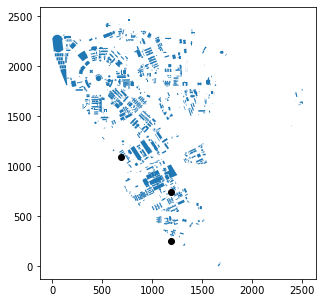

In [31]:
# Plot de paradas de ÔNIBUS
ax = mapa_normalizado['geometry'].plot(figsize=(12, 5))
pontos_onibus_norm_df.plot(ax=ax, color="black")

In [32]:
a =  mapa_normalizado.iloc[mapa_normalizado.shape[0]-3: mapa_normalizado.shape[0]]
a

,id,building_number,building_name,unit,geometry
1168,0.0,4.0,Inova P&D,INOVA,"POLYGON ((1498.018 2134.044, 1498.209 2134.395..."
1169,0.0,0.0,Instituto de Otorrinolaringologia,None,"POLYGON ((1186.929 1019.863, 1202.243 992.924,..."
1170,-1000.0,-1000.0,FUNCAMP,{aaa},"POLYGON ((759.221 2471.148, 759.221 2459.412, ..."


# Criação de dataset dos Prédios da Unicamp

- Create a xml file with Unicamp Building shapes & height
- The outuput xml file will serve as input of NS3

In [33]:
# estudando e tratando a string Polygon
polygon_str = str(mapa_normalizado['geometry'][0])
polygon_coords = polygon_str[polygon_str.find("(") + 2:]
polygon_coords = polygon_coords[ : polygon_coords.find(")")]
polygon_coords

'653.7600999996066 1952.626000000164, 653.9206999996677 1944.120199999772, 637.80979999993 1943.906200000085, 637.80979999993 1952.358500000089, 653.7600999996066 1952.626000000164, 653.7600999996066 1952.626000000164'

In [34]:
# estudando e tratando a string Polygon para o formato aceito pelo módulo de obstáculo
def polygon_to_str(polygon_coords):
    poly_list = polygon_coords.split(", ")
    poly_final_str = ""
    for i in range(len(poly_list)):
        poly_final_str = poly_final_str + poly_list[i].replace(" ", ",") + " "

    return poly_final_str

# print(polygon_to_str(polygon_coords))

In [35]:
# Criando xml dataset
import os
import random
from xml.dom import minidom

root = minidom.Document()
  
xml = root.createElement('additional') 
xml.setAttribute('xmlns:xsi','http://www.w3.org/2001/XMLSchema-instance')
xml.setAttribute('xsi:noNamespaceSchemaLocation','http://sumo.dlr.de/xsd/additional_file.xsd')
root.appendChild(xml)

for i in range(len(mapa_normalizado['geometry'])):   
    
    polygon_str = str(mapa_normalizado['geometry'][i])
    polygon_coords = polygon_str[polygon_str.find("(") + 2:]
    polygon_coords = polygon_coords[ : polygon_coords.find(")")]
    
    productChild = root.createElement('poly')
    productChild.setAttribute('id', str(int(mapa_normalizado['id'][i])))
    productChild.setAttribute('type', 'building')
    productChild.setAttribute('color', '255.0,230.0,230.0')
    productChild.setAttribute('layer', '-1.0')
    productChild.setAttribute('fill', '1')
    productChild.setAttribute('height', str(random.uniform(3, 25)))
    productChild.setAttribute('shape', polygon_to_str(polygon_coords))
  
    xml.appendChild(productChild)
  
xml_str = root.toprettyxml(indent ="\t") 
  
save_path_file = "predios_unicamp_dataset.xml"
  
with open(save_path_file, "w") as f:
    f.write(xml_str) 


In [36]:
print("SHAPE:", mapa_normalizado.shape)

SHAPE: (1171, 5)


# Criação de dataset do posicionamento dos Coletores

- Buscar e Mapear predios que contem coletores
    - https://www.prefeitura.unicamp.br/2016/02/26/programa-de-coleta-de-pilhas-e-baterias-instalacao-de-coletores/
    - https://unicamp-arcgis.maps.arcgis.com/apps/View/index.html?appid=1d96ada62af4451bb4972b9779d09e66

- Rotular prédios sem nome
    - Anotar centroids de prédios mapeados
- Criar dataset de posicionamento de nós

In [37]:
mapa_normalizado.query('id ==' + str(459.0))

,id,building_number,building_name,unit,geometry
513,459.0,1.0,PREDIO DO IMECC,INSTITUTO DE MATEMÁTICA ESTATÍSTICA E COMPUTAÇ...,"POLYGON ((700.738 2035.325, 700.678 2033.525, ..."


## Rotular prédios sem nome

In [38]:
# Dataset de Prédios com coletores
building_label = {
    "1321.0":"INOVA",
    "535.0": "BC",
    "802.0": "CBMEG",
    "845.0": "CCUEC",
    "1037.0": "GASTROCENTRO",
    "1115.0": "CEPETRO",
    "1038.0": "HEMOCENTRO",
    "960.0": "CEMEQ",
    "671.0": "CBI",
    "663.0": "CBII",
    "533.0": "CDC",
    "29.0": "DGA",
    "9.0": "DGRH",
    "1211.0": "DEdIC",
    "1220.0": "Sergio porto",
    "1238.0": "FCM",
    "727.0": "FEF",
    "1240.0": "FEnf",
    "881.0": "FEAGRI",
    "1282.0": "FEC",
    "300.0": "FEA",
    "278.0": "FEEC",
    "1151.0": "FEM",
    "971.0": "FEQ",
    "-1000.0": "FUNCAMP",
    "1.0": "GR",
    "195.0": "GGO", 
    "59.0": "HC",
    "513.0": "IA",
    "604.0": "IB",
    "776.0": "IC",
    "488.0": "IEL",
    "1112.0": "IFCH", 
    "441.0": "IFGW",
    "182.0": "IG-BAIXO",
    "1134.0": "IG-CIMA", 
    "459.0": "IMECC",
    "376.0": "IQ",
    "4.0": "PREFEITURA",
    "198.0": "RA",
    "1309.0": "RS",
    "531.0": "RU",        
} 

nodes_df = gpd.GeoDataFrame(columns=['id', 'number','name', 'geometry', 'centroid'])

# Labeling buildings
aux = 0
for key, value in building_label.items():
    building = mapa_normalizado.query('id ==' + str(key))
    building_n = building.copy()
    nodes_df.loc[aux, 'name'] = value
    nodes_df.loc[aux, ['id']] = building_n['id'].values   
    nodes_df.loc[aux, ['number']] = building_n['building_number'].values      
    nodes_df.loc[aux, ['geometry']] = building_n['geometry'].values
#     nodes_df.loc[aux, ['centroid']] = building_n['centroid'].values
    
    aux = aux + 1
    
nodes_df.head()
# nodes_df.shape


,id,number,name,geometry,centroid
0,1321.0,1.0,INOVA,"POLYGON ((1544.734 2191.631, 1539.771 2182.560...",NaN
1,535.0,5.0,BC,"POLYGON ((334.799 1989.172, 314.589 1966.397, ...",NaN
2,802.0,9.0,CBMEG,"POLYGON ((1534.930 1669.334, 1536.892 1669.233...",NaN
3,845.0,8.0,CCUEC,"POLYGON ((1136.915 1848.717, 1136.349 1837.946...",NaN
4,1037.0,6.0,GASTROCENTRO,"POLYGON ((1193.857 696.854, 1202.814 677.182, ...",NaN


In [39]:
nodes_df['centroid'] = nodes_df.centroid
nodes_df.head()

,id,number,name,geometry,centroid
0,1321.0,1.0,INOVA,"POLYGON ((1544.734 2191.631, 1539.771 2182.560...",POINT (1527.405 2180.212)
1,535.0,5.0,BC,"POLYGON ((334.799 1989.172, 314.589 1966.397, ...",POINT (297.312 1965.812)
2,802.0,9.0,CBMEG,"POLYGON ((1534.930 1669.334, 1536.892 1669.233...",POINT (1535.554 1646.181)
3,845.0,8.0,CCUEC,"POLYGON ((1136.915 1848.717, 1136.349 1837.946...",POINT (1149.490 1831.086)
4,1037.0,6.0,GASTROCENTRO,"POLYGON ((1193.857 696.854, 1202.814 677.182, ...",POINT (1186.796 667.866)


<AxesSubplot:>

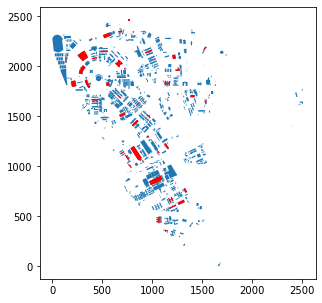

In [40]:
ax = mapa_normalizado['geometry'].plot(figsize=(12, 5))

# predios com coletores
nodes_df['geometry'].plot(ax=ax, color="red")

<AxesSubplot:>

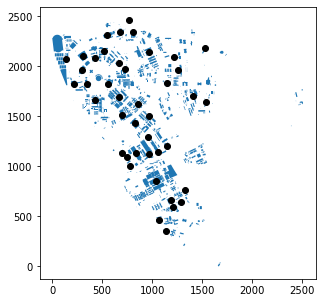

In [41]:
ax = mapa_normalizado['geometry'].plot(figsize=(12, 5))

# centroids
nodes_df["centroid"].plot(ax=ax, color="black")

In [42]:
nodes_df.shape[0]

42

In [43]:
nodes_df.iloc[nodes_df.shape[0]-10:nodes_df.shape[0]]

,id,number,name,geometry,centroid
32,1112.0,3.0,IFCH,"POLYGON ((816.603 2352.050, 816.711 2347.439, ...",POINT (811.661 2345.528)
33,441.0,5.0,IFGW,"POLYGON ((728.643 1983.953, 728.808 1968.908, ...",POINT (724.497 1976.394)
34,182.0,8.0,IG-BAIXO,"POLYGON ((974.581 1126.027, 962.418 1118.425, ...",POINT (968.081 1123.219)
35,1134.0,1.1,IG-CIMA,"POLYGON ((586.143 2307.745, 519.987 2282.064, ...",POINT (546.812 2311.007)
36,459.0,1.0,IMECC,"POLYGON ((700.738 2035.325, 700.678 2033.525, ...",POINT (666.715 2029.884)
37,376.0,16.0,IQ,"POLYGON ((657.659 1717.684, 671.677 1703.719, ...",POINT (670.199 1698.567)
38,4.0,2.0,PREFEITURA,"POLYGON ((784.329 1011.532, 784.757 1011.053, ...",POINT (777.679 1004.918)
39,198.0,10.0,RA,"POLYGON ((969.003 1298.361, 967.361 1296.699, ...",POINT (956.600 1298.186)
40,1309.0,1.0,RS,"POLYGON ((1229.252 2115.274, 1235.292 2090.603...",POINT (1218.197 2096.661)
41,531.0,1.0,RU,"POLYGON ((229.926 1860.477, 241.953 1803.958, ...",POINT (213.981 1827.408)


# Criar dataset de posicionamento de nós

In [44]:
# GENERATE BUILDINGS CSV FILE

#---- create a csv file
def create_csv(title, colunms_names):
    with open(title,"w+") as file:
        writer = csv.writer(file, delimiter=",")
        writer.writerow(colunms_names)


#---- add row on csv file
def add_csv_rows(ns3_settings, colunms_names, title):
    for colunm in ns3_settings:
        if len(colunm) == len(colunms_names):
            with open(title,"a") as file:
                writer = csv.writer(file, delimiter=",")
                writer.writerow([x for x in colunm])


In [45]:
colunms_names  = ['id', 'name', 'x', 'y', 'z']

nodes_pos = []
for i in range(len(nodes_df.geometry)):
    # tratando a string Point
    point_str = str(nodes_df['centroid'][i])
    point_coords = point_str[point_str.find("(") + 1:]
    point_coords = point_coords[ : point_coords.find(")")]
#     print(i, " - ",point_coords)
    x = point_coords.split()[0]
    y = point_coords.split()[1]
    z = 1.5

    items_per_row = [nodes_df.loc[i]['id'], nodes_df.loc[i]['name'], x, y, z]
    nodes_pos.append(items_per_row)


# ADD casos especiais
# def add_node_dataset_rows(geodataset, ref_osm_id, name, point):
items_per_row = [-10001,"CCS", pt_CCS.x,  pt_CCS.y, 1.5]
nodes_pos.append(items_per_row)
items_per_row = [-10002,"EB", pt_EB.x, pt_EB.y, 1.5]
nodes_pos.append(items_per_row)
items_per_row = [-10003,"PO-RM", norm_points[0].x, norm_points[0].y, 1.5]  # parada_RM
nodes_pos.append(items_per_row)
items_per_row = [-10004,"PO-AL", norm_points[1].x, norm_points[1].y, 1.5] # parada_AL
nodes_pos.append(items_per_row)
items_per_row = [-10005,"PO-VB", norm_points[2].x, norm_points[2].y, 1.5] # parada_VB
nodes_pos.append(items_per_row)


In [46]:
output_filename = 'coletores_pos_dataset.csv'
create_csv(output_filename, colunms_names)
add_csv_rows(nodes_pos, colunms_names, output_filename)

In [47]:
# Visualizando dataset criado
node_pos_df = pd.read_csv("coletores_pos_dataset.csv") 
print("DATASET SHAPE:", node_pos_df.shape)
node_pos_df.head()

DATASET SHAPE: (47, 5)


,id,name,x,y,z
0,1321.0,INOVA,1527.405075,2180.212233,1.5
1,535.0,BC,297.311734,1965.812273,1.5
2,802.0,CBMEG,1535.553550,1646.180816,1.5
3,845.0,CCUEC,1149.489906,1831.086023,1.5
4,1037.0,GASTROCENTRO,1186.795533,667.866479,1.5


In [48]:
node_pos_df.iloc[node_pos_df.shape[0]-10:node_pos_df.shape[0]]

,id,name,x,y,z
37,376.0,IQ,670.198697,1698.567029,1.5
38,4.0,PREFEITURA,777.679360,1004.918245,1.5
39,198.0,RA,956.600038,1298.185503,1.5
40,1309.0,RS,1218.197469,2096.661066,1.5
41,531.0,RU,213.981127,1827.408356,1.5
42,-10001.0,CCS,955.805000,1150.583000,1.5
43,-10002.0,EB,905.000000,1250.583000,1.5
44,-10003.0,PO-RM,684.091527,1098.759834,1.5
45,-10004.0,PO-AL,1188.779864,252.894795,1.5
46,-10005.0,PO-VB,1192.235499,740.328771,1.5


<AxesSubplot:>

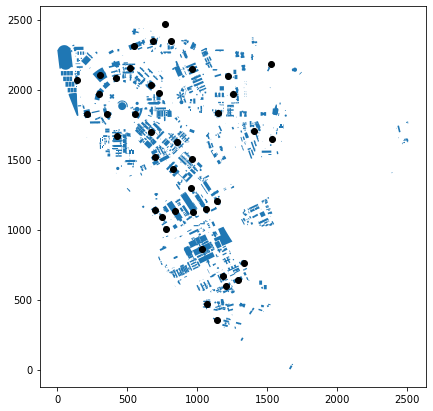

In [49]:
ax = mapa_normalizado['geometry'].plot(figsize=(15, 7))

# centroids
nodes_df["centroid"].plot(ax=ax, color="black")


# Salvando Mapa de prédios da Unicamp Normalizado (shapefile)

In [50]:
# verificando se não foi atribuindo um CRS anteriormente
mapa_normalizado.crs is None

True

In [51]:
# atribuindo um CRS
mapa_normalizado = mapa_normalizado.set_crs('epsg:31983')
mapa_normalizado.crs  

<Projected CRS: EPSG:31983>
Name: SIRGAS 2000 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - 48°W to 42°W
- bounds: (-48.0, -33.5, -42.0, 5.13)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [57]:
# SALVANDO MAPA NORMALIZADO DE PRÉDIOS no formato Shapefile
mapa_normalizado.to_file('mapa_predios_unicamp_normalizado.shp')

# # Testando abrir arquivo salvo
unicamp_gdf = gpd.read_file('mapa_predios_unicamp_normalizado.shp')

<ipython-input-57-ab1ecf111ccf>:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  mapa_normalizado.to_file('mapa_predios_unicamp_normalizado.shp')


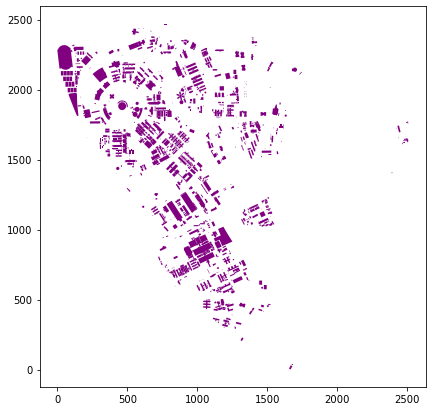

In [58]:
ax = unicamp_gdf['geometry'].plot(figsize=(15, 7), color='purple')

# Elevação

In [59]:
# Abrindo Dataset de Elevação (Google Maps API)
elevation_df = pd.read_csv("unicamp_centroids_elevation.csv") 
print("DATASET SHAPE:", elevation_df.shape)

elevation_df.rename(columns={'Unnamed: 0': 'index'}, inplace=True)

elevation_df.head()

DATASET SHAPE: (1171, 7)


,index,latitude,longitude,elevation,maps_lat,maps_long,resolution
0,0,-22.816526,-47.067957,600.368958,-22.81653,-47.06796,152.703232
1,1,-22.825453,-47.064466,625.860535,-22.82545,-47.06447,152.703232
2,2,-22.816429,-47.062007,626.047119,-22.81643,-47.06201,152.703232
3,3,-22.827770,-47.061961,633.660645,-22.82777,-47.06196,152.703232
4,4,-22.827630,-47.062190,632.446960,-22.82763,-47.06219,152.703232


In [60]:
mapa_normalizado.query('id ==' + str(175.0))

,id,building_number,building_name,unit,geometry
189,175.0,1.0,ENGª BÁSICA E NEPAM E FEEC-ELETRÔNICA E MICRO-...,REITORIA-PRG,"POLYGON ((968.874 1190.621, 981.679 1170.861, ..."


In [61]:
# Dataset de Prédios com coletores
building_index = {
    "701":"INOVA", "765": "BC", "688": "CBMEG", "600": "CCUEC", "315": "GASTROCENTRO", "539": "CEPETRO",
    "852": "HEMOCENTRO", "219": "CEMEQ", "760": "CBI", "753": "CBII", "787": "CDC", "193": "DGA",
    "209": "DGRH", "863": "DEdIC", "297": "Sergio porto", "867": "FCM", "790": "FEF", "880": "FEnf",
    "674": "FEAGRI", "2": "FEC", "253": "FEA", "234": "FEEC", "286": "FEM", "396": "FEQ",
    "1170": "FUNCAMP", "39": "GR", "212": "GGO", "115": "HC", "24": "IA", "441": "IB", "571": "IC",
    "525": "IEL", "540": "IFCH", "399": "IFGW", "183": "IG-BAIXO", "1066": "IG-CIMA", "513": "IMECC",
    "341": "IQ", "203": "PREFEITURA", "37": "RA", "636": "RS", "775": "RU",        
} 

In [62]:
# a = elevation_df.query('index ==' + str(701))
# b = a['elevation'].values[0]
# b

In [64]:
teste_df = gpd.GeoDataFrame(columns=['elevation'])

# Labeling buildings
aux = 0
for key, value in building_index.items():
    building = elevation_df.query('index ==' + str(key))
    building_n = building.copy()
    teste_df.loc[aux, 'elevation'] = building_n['elevation'].values[0]
    aux = aux + 1

print(teste_df.shape)
# teste_df.head()

(42, 1)


In [66]:
building = elevation_df.query('index ==' + str(189)) ## CCS e EB
building_n = building.copy()
teste_df.loc[aux, 'elevation'] = building_n['elevation'].values[0] # CCS
aux = aux + 1
teste_df.loc[aux, 'elevation'] = building_n['elevation'].values[0] # EB
aux = aux + 1

print(teste_df.shape)
# teste_df.head()

(46, 1)


In [67]:
# Elevação Paradas de ônibus
# parada_RM = Point(-47.0677, -22.8242) 
# parada_AL = Point(-47.0629, -22.8319) 
# parada_VB = Point(-47.0628, -22.8275)

import time
import requests

def get_point_elevation(lat, lng):
    receive = requests.get('https://api.opentopodata.org/v1/aster30m?locations=' + str(lat) + ','+ str(lng))
    data = receive.json()
#     print(data['results'][0]['elevation'])
    return float(data['results'][0]['elevation'])


parada_RM_elev = get_point_elevation(-22.8242, -47.0677)
time.sleep(1)
parada_AL_elev = get_point_elevation(-22.8319, -47.0629)
time.sleep(1)
parada_VB_elev = get_point_elevation(-22.8275, -47.0628)
print(parada_RM_elev, parada_AL_elev, parada_VB_elev)


# add elevations on df
teste_df.loc[aux, 'elevation'] = parada_RM_elev
aux = aux + 1
teste_df.loc[aux, 'elevation'] = parada_AL_elev
aux = aux + 1
teste_df.loc[aux, 'elevation'] = parada_VB_elev
aux = aux + 1

print(teste_df.shape)
teste_df.head()

604.0 638.0 624.0
(49, 1)


,elevation
0,644.45874
1,602.154968
2,652.513123
3,616.78894
4,635.025085


In [68]:
node_pos_df['elevation'] = teste_df['elevation']
node_pos_df.head()

,id,name,x,y,z,elevation
0,1321.0,INOVA,1527.405075,2180.212233,1.5,644.45874
1,535.0,BC,297.311734,1965.812273,1.5,602.154968
2,802.0,CBMEG,1535.553550,1646.180816,1.5,652.513123
3,845.0,CCUEC,1149.489906,1831.086023,1.5,616.78894
4,1037.0,GASTROCENTRO,1186.795533,667.866479,1.5,635.025085


In [69]:
node_pos_df.iloc[node_pos_df.shape[0]-10:node_pos_df.shape[0]]

,id,name,x,y,z,elevation
37,376.0,IQ,670.198697,1698.567029,1.5,606.811218
38,4.0,PREFEITURA,777.679360,1004.918245,1.5,621.810242
39,198.0,RA,956.600038,1298.185503,1.5,612.331543
40,1309.0,RS,1218.197469,2096.661066,1.5,624.28363
41,531.0,RU,213.981127,1827.408356,1.5,603.169128
42,-10001.0,CCS,955.805000,1150.583000,1.5,617.214233
43,-10002.0,EB,905.000000,1250.583000,1.5,617.214233
44,-10003.0,PO-RM,684.091527,1098.759834,1.5,617.214233
45,-10004.0,PO-AL,1188.779864,252.894795,1.5,617.214233
46,-10005.0,PO-VB,1192.235499,740.328771,1.5,604.0


# Criar dataset de posicionamento de nós

In [73]:
# salvando
node_pos_df.to_csv("coletores_pos_dataset_elev.csv", encoding='utf-8')

In [74]:
# visualizando dataset
# Visualizando dataset criado
df = pd.read_csv("coletores_pos_dataset_elev.csv") 
print("DATASET SHAPE:", df.shape)
df.head()

DATASET SHAPE: (47, 7)


,Unnamed: 0,id,name,x,y,z,elevation
0,0,1321.0,INOVA,1527.405075,2180.212233,1.5,644.458740
1,1,535.0,BC,297.311734,1965.812273,1.5,602.154968
2,2,802.0,CBMEG,1535.553550,1646.180816,1.5,652.513123
3,3,845.0,CCUEC,1149.489906,1831.086023,1.5,616.788940
4,4,1037.0,GASTROCENTRO,1186.795533,667.866479,1.5,635.025085
